In [7]:
# Importations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import openslide
import torch

from tilingtool.core import histo
from tilingtool.filters.matter_detection import BUNet
from tilingtool.extractors import ResNet50Keras

# Constants
DATA_PATH = '/STORAGE/data/Camelyon_clean/slides'

In [17]:
# Create dataframe
filenames = os.listdir(DATA_PATH)

df = pd.DataFrame(data=filenames, columns=['filename'])
df['label'] = df.filename.apply(lambda x:1 if x.split('_')[0] == 'Tumor' else 0)
df['test'] = df.filename.apply(lambda x:1 if x.split('_')[0] == 'Test' else 0)
df.head()

,filename,label,test
0,Test_016.tif,0,1
1,Normal_006.tif,0,0
2,Normal_122.tif,0,0
3,Tumor_047.tif,1,0
4,Normal_125.tif,0,0


In [18]:
df[df.test == 0].label.value_counts()

0    199
1     70
Name: label, dtype: int64

## OpenSlide

/STORAGE/data/Camelyon_clean/slides/Normal_003.tif 0
philips
10
(97792, 221184)
((97792, 221184), (48896, 110592), (24448, 55296), (12224, 27648), (6112, 13824), (3056, 6912), (1528, 3456), (764, 1728), (382, 864), (191, 432))
(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)
<PIL.Image.Image image mode=RGB size=177x400 at 0x7F60FDAC83D0>


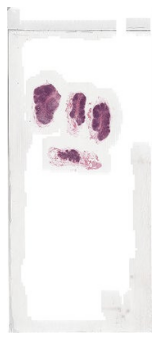

In [22]:
idx = np.random.randint(0, len(df), 1)[0]
slide_path = os.path.join(DATA_PATH, df.filename.iloc[idx])
print(slide_path, df.label.iloc[idx])

slide = openslide.open_slide(slide_path)

print(slide.detect_format(slide_path))
print(slide.level_count)
print(slide.dimensions)
print(slide.level_dimensions)
print(slide.level_downsamples)
#print(slide.properties)
#print(slide.associated_images)

thumbnail = slide.get_thumbnail(size=(400, 400))

print(thumbnail)
plt.figure(figsize=(6, 6)); plt.imshow(thumbnail); plt.axis('off'); plt.show()

#location = (20000, 20000)
#level = 0
#size = (256, 256)
#tile = slide.read_region(location, level, size)
#print(tile)
#plt.figure(figsize=(6, 6)); plt.imshow(tile); plt.axis('off'); plt.show()

#print(slide.get_best_level_for_downsample(10))

slide.close()

## TilingToolv2

In [88]:
slide_path = os.path.join(DATA_PATH, 'Normal_001.tif')
slide = openslide.OpenSlide(slide_path)

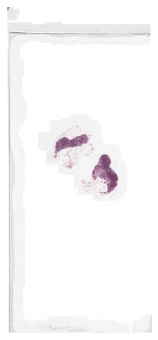

In [89]:
thumbnail = slide.get_thumbnail(size=(400, 400))
plt.figure(figsize=(6, 6)); plt.imshow(thumbnail); plt.axis('off'); plt.show()

In [90]:
matter_detector = BUNet()

2021-11-22 17:32:00.941 | INFO     | tilingtool.filters.matter_detection.bunet:__init__:42 - Loading BUNet from classic-algo's hub.


In [91]:
mask = matter_detector(slide)
mask = np.expand_dims(mask, axis=2)
mask.shape

(13824, 6112, 1)

In [97]:
thumbnail = slide.get_thumbnail(size=(mask.shape[1], mask.shape[0]))
thumbnail = np.array(thumbnail)
thumbnail.shape

(13824, 6112, 3)

In [98]:
mask.shape, thumbnail.shape

((13824, 6112, 1), (13824, 6112, 3))

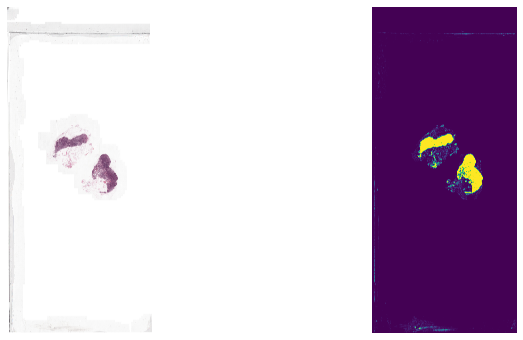

In [99]:
plt.figure(figsize=(12, 6))
plt.subplot(121); plt.imshow(thumbnail); plt.axis('off')
plt.subplot(122); plt.imshow(mask); plt.axis('off')
plt.show()

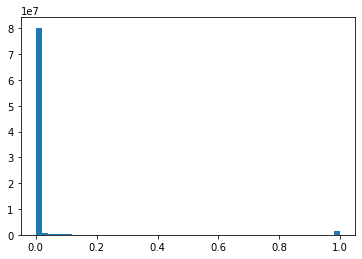

In [100]:
plt.hist(mask.ravel(), bins=50, range=(0., 1.)); plt.show()

In [105]:
masked_thumbnail = (mask > 0.8) * thumbnail + 255 * (mask <= 0.8)

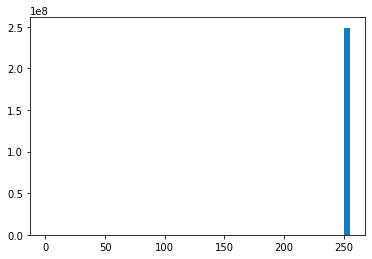

In [106]:
plt.hist(masked_thumbnail.ravel(), bins=50); plt.show()

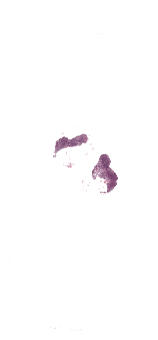

In [107]:
plt.figure(figsize=(6, 6)); plt.imshow(masked_thumbnail); plt.axis('off'); plt.show()

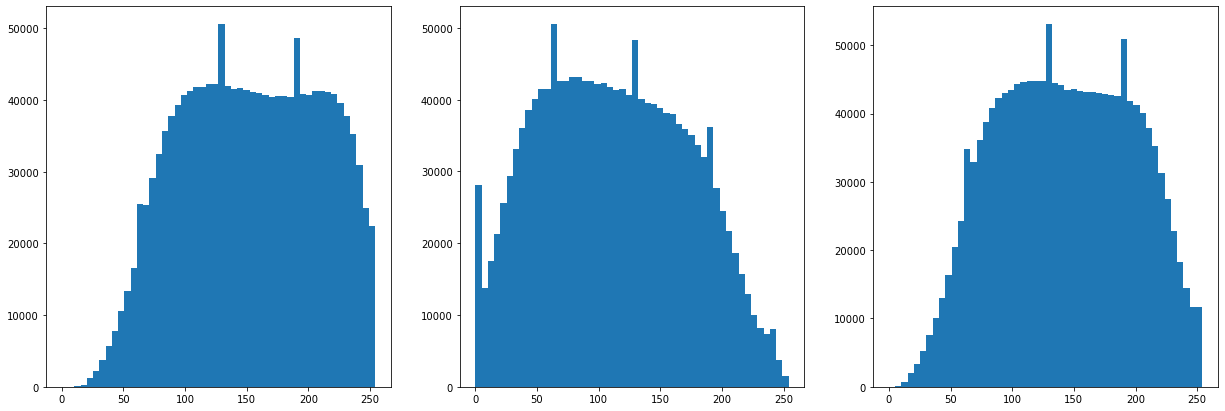

In [141]:
plt.figure(figsize=(21, 7))
plt.subplot(131); plt.hist(masked_thumbnail[..., 0].ravel(), bins=50, range=(0, 254))
plt.subplot(132); plt.hist(masked_thumbnail[..., 1].ravel(), bins=50, range=(0, 254))
plt.subplot(133); plt.hist(masked_thumbnail[..., 2].ravel(), bins=50, range=(0, 254))
plt.show()

In [119]:
(masked_thumbnail.ravel() < 255).sum()

4652524

In [132]:
tmp = masked_thumbnail[..., 0].ravel()
tmp.shape, tmp[(tmp < 255)].shape

((84492288,), (1524717,))

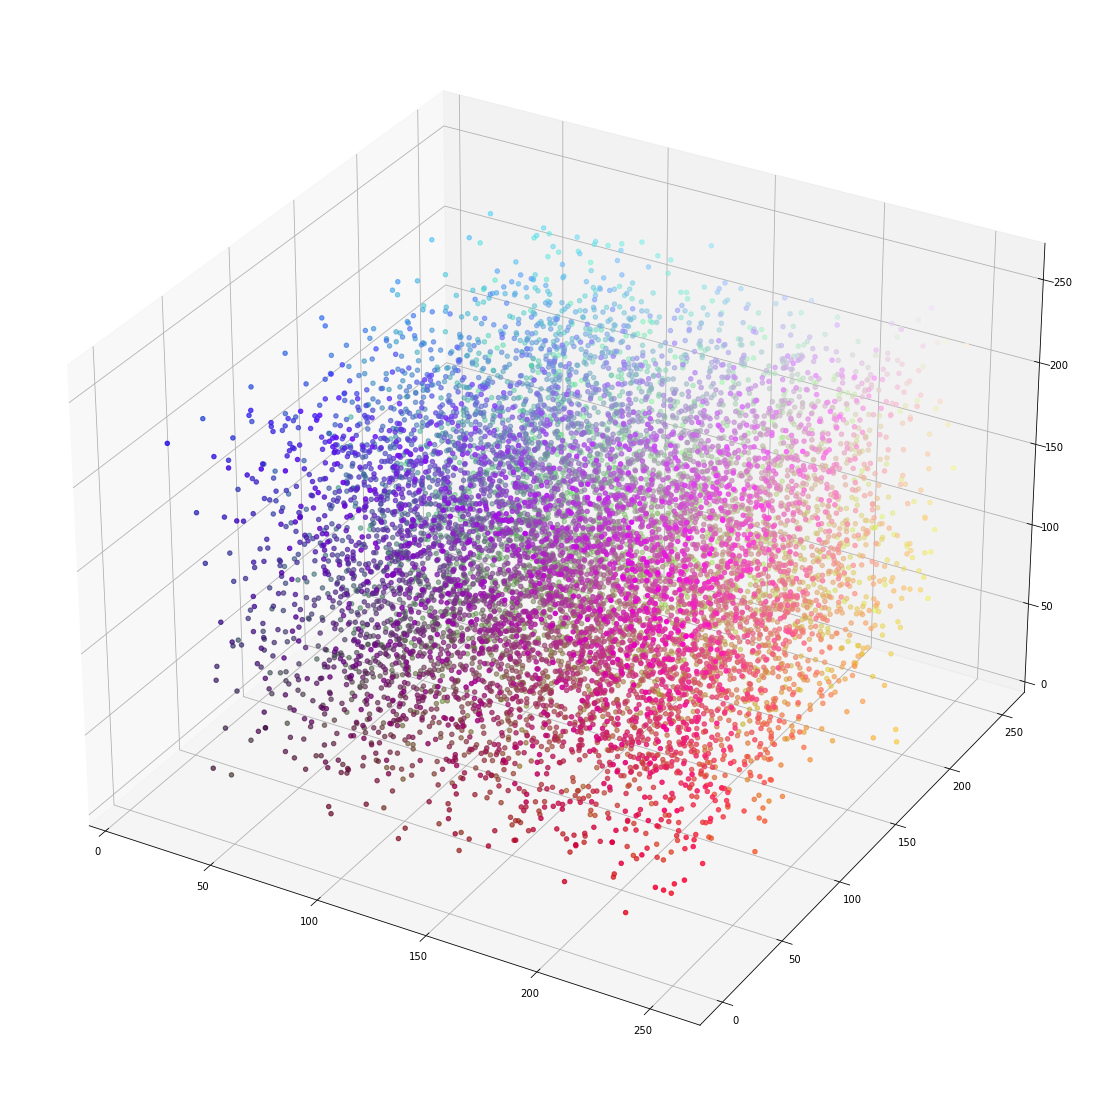

In [169]:
N = 10000

tmp = masked_thumbnail[..., 0].ravel()
tmp = tmp[(tmp < 255)]
indices = np.random.randint(0, len(tmp), N)
xs = tmp[indices]

tmp = masked_thumbnail[..., 1].ravel()
ys = tmp[(tmp < 255)][indices]

tmp = masked_thumbnail[..., 2].ravel()
zs = tmp[(tmp < 255)][indices]

c = []
for x,y,z in zip(xs, ys, zs):
    c.append([x/255., y/255., z/255.])

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, c=c)
plt.show()

In [4]:

matter_detector = BUNet()
extractor = ResNet50Keras()


#mask, features, metadata = histo.extract(slide,
#                                         matter_detector,
#                                         extractor)

2021-11-22 17:11:17.871 | INFO     | tilingtool.filters.matter_detection.bunet:__init__:42 - Loading BUNet from classic-algo's hub.
/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
2021-11-22 17:11:25.748 | INFO     | tilingtool.extractors.resnet50_keras:__init__:37 - Loading ResNet50Keras from classic-algo's hub.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_19968/3520566837.py", line 5, in <module>
    mask, features, metadata = histo.extract(slide,
  File "/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/tilingtool/core/histo.py", line 239, in extract
    slide_mask = matter_filter(slide, default_mpp_max=default_mpp_max)
  File "/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/tilingtool/filters/matter_detection/matter_filter.py", line 147, in __call__
    tile_masks = self.forward(tiles)
  File "/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/tilingtool/filters/matter_detection/bunet.py", line 94, in forward
    masks = torch.sigmoid(self.bunet(tiles.to(self.device)))
  File "/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_19968/3520566837.py", line 5, in <module>
    mask, features, metadata = histo.extract(slide,
  File "/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/tilingtool/core/histo.py", line 239, in extract
    slide_mask = matter_filter(slide, default_mpp_max=default_mpp_max)
  File "/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/tilingtool/filters/matter_detection/matter_filter.py", line 147, in __call__
    tile_masks = self.forward(tiles)
  File "/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/tilingtool/filters/matter_detection/bunet.py", line 94, in forward
    masks = torch.sigmoid(self.bunet(tiles.to(self.device)))
  File "/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1

TypeError: object of type 'NoneType' has no len()